In [6]:
# This cell took more than 30 minutes to run
# Gather all the pages that are linked to the "2020 Summer Olympics page" on Wikipedia
import wikipedia

def filter_olympic_2020_titles(titles):
    # Get the titles which are related to Olympic games hosted in 2020, given a list of titles
    titles = [title for title in titles if '2020' in title and 'olympic' in title.lower()]

    return titles

def get_wiki_page(title):
    # Get the wikipedia page given a title
    try:
        return wikipedia.page(title)
    except wikipedia.exceptions.DisambiguationError as e:
        return wikipedia.page(e.options[0])
    except wikipedia.exceptions.PageError as e:
        return None
    except wikipedia.exceptions.ReadTimeout:
        return None

def recursively_find_all_pages(titles, titles_so_far=set()):
    # Recursively find all the pages that are linked to the Wikipedia titles in the list
    all_pages = []

    titles = list(set(titles) - titles_so_far)
    titles = filter_olympic_2020_titles(titles)
    titles_so_far.update(titles)
    for title in titles:
        print(title + " [ " + str(len(all_pages)) + " ] ")    # log to check progress
        page = get_wiki_page(title)
        if page is None:
            continue
        all_pages.append(page)

        new_pages = recursively_find_all_pages(page.links, titles_so_far)
        for pg in new_pages:
            if pg.title not in [p.title for p in all_pages]:
                all_pages.append(pg)
        titles_so_far.update(page.links)
    return all_pages


pages = recursively_find_all_pages(["2020 Summer Olympics"])
len(pages)

2020 Summer Olympics 0
Tanzania at the 2020 Summer Olympics 0
Athletics at the 2020 Summer Olympics – Men's marathon 0
Athletics at the 2020 Summer Olympics – Men's decathlon 0
Athletics at the 2020 Summer Olympics – Women's 400 metres hurdles 1
2020 United States Olympic Trials (track and field) 0
Athletics at the 2020 Summer Olympics – Women's 3000 metres steeplechase 2
Athletics at the 2020 Summer Olympics – Men's discus throw 3
Athletics at the 2020 Summer Olympics – Women's long jump 4
Athletics at the 2020 Summer Olympics – Men's javelin throw 5
Athletics at the 2020 Summer Olympics – Men's 10,000 metres 6
Athletics at the 2020 Summer Olympics – Women's 4 × 400 metres relay 6
Athletics at the 2020 Summer Olympics – Men's 400 metres hurdles 7
Athletics at the 2020 Summer Olympics – Women's 200 metres 8
Athletics at the 2020 Summer Olympics – Men's triple jump 9
Athletics at the 2020 Summer Olympics – Mixed 4 × 400 metres relay 10
Athletics at the 2020 Summer Olympics – Men's 1500 

903

In [22]:
import re
from typing import Set
from transformers import GPT2TokenizerFast
from nltk.tokenize import sent_tokenize

tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(text: str) -> int:
    # Count the number of tokens in a string
    return len(tokenizer.encode(text, truncation=True))

def reduce_long(
        long_text: str, long_text_tokens: bool = False, max_len: int = 590
) -> str:
    # Reduce a long text to a maximum of `max_len` tokens by potentially cutting at a sentence end
    if not long_text_tokens:
        long_text_tokens = count_tokens(long_text)
    if long_text_tokens > max_len:
        sentences = sent_tokenize(long_text.replace("\n", " "))
        ntokens = 0
        for i, sentence in enumerate(sentences):
            ntokens += 1 + count_tokens(sentence)
            if ntokens > max_len:
                return ". ".join(sentences[:i]) + "."

    return long_text

discard_categories = ['See also', 'References', 'External links', 'Further reading', "Footnotes",
                      "Bibliography", "Sources", "Citations", "Literature", "Footnotes", "Notes and references",
                      "Photo gallery", "Works cited", "Photos", "Gallery", "Notes", "References and sources",
                      "References and notes",]


def extract_sections(
        wiki_text: str,
        title: str,
        max_len: int = 1500,
        discard_categories: Set[str] = discard_categories,
) -> str:
    # Extract the sections of a Wikipedia page, discarding the references and other low information sections
    if len(wiki_text) == 0:
        return []

    # Find all headings and the coresponding contents
    headings = re.findall("==+ .* ==+", wiki_text)
    for heading in headings:
        wiki_text = wiki_text.replace(heading, "==+ !! ==+")
    contents = wiki_text.split("==+ !! ==+")
    contents = [c.strip() for c in contents]
    assert len(headings) == len(contents) - 1

    cont = contents.pop(0).strip()
    outputs = [(title, "Summary", cont, count_tokens(cont)+4)]

    # Discard the discard categories, accounting for a tree structure
    max_level = 100
    keep_group_level = max_level
    remove_group_level = max_level
    nheadings, ncontents = [], []
    for heading, content in zip(headings, contents):
        plain_heading = " ".join(heading.split(" ")[1:-1])
        num_equals = len(heading.split(" ")[0])
        if num_equals <= keep_group_level:
            keep_group_level = max_level

        if num_equals > remove_group_level:
            if (
                    num_equals <= keep_group_level
            ):
                continue
        keep_group_level = max_level
        if plain_heading in discard_categories:
            remove_group_level = num_equals
            keep_group_level = max_level
            continue
        nheadings.append(heading.replace("=", "").strip())
        ncontents.append(content)
        remove_group_level = max_level

    # Count the tokens of each section
    ncontent_ntokens = [
        count_tokens(c)
        + 3
        + count_tokens(" ".join(h.split(" ")[1:-1]))
        - (1 if len(c) == 0 else 0)
        for h, c in zip(nheadings, ncontents)
    ]

    # Create a tuple of (title, section_name, content, number of tokens)
    outputs += [(title, h, c, t) if t<max_len
                else (title, h, reduce_long(c, max_len), count_tokens(reduce_long(c,max_len)))
                for h, c, t in zip(nheadings, ncontents, ncontent_ntokens)]

    return outputs

In [23]:
# Example page being processed into sections
# https://en.wikipedia.org/wiki/Bermuda_at_the_2020_Summer_Olympics
bermuda_page = get_wiki_page('Bermuda at the 2020 Summer Olympics')
ber = extract_sections(bermuda_page.content, bermuda_page.title)

# Example section
ber[-1]

('Bermuda at the 2020 Summer Olympics',
 'Equestrian',
 "Bermuda entered one dressage rider into the Olympic competition by finishing in the top four, outside the group selection, of the individual FEI Olympic Rankings for Groups D and E (North, Central, and South America), marking the country's recurrence to the sport after an eight-year absence. The quota was later withdrawn, following an injury of Annabelle Collins' main horse Joyero and a failure to obtain minimum eligibility requirements (MER) aboard a new horse Chuppy Checker.",
 104)

In [24]:
import pandas as pd

cnt = 0;
res = []
for page in pages:
    cnt+=1
    print(cnt, "/", len(pages))
    res += extract_sections(page.content, page.title)
df = pd.DataFrame(res, columns=["title", "heading", "content", "tokens"])
df = df[df.tokens>40]
df = df.drop_duplicates(['title','heading'])
df = df.reset_index().drop('index',axis=1) # reset index
df.head()

1 / 903
2 / 903
3 / 903
4 / 903
5 / 903
6 / 903
7 / 903
8 / 903
9 / 903
10 / 903
11 / 903
12 / 903
13 / 903
14 / 903
15 / 903
16 / 903
17 / 903
18 / 903
19 / 903
20 / 903
21 / 903
22 / 903
23 / 903
24 / 903
25 / 903
26 / 903
27 / 903
28 / 903
29 / 903
30 / 903
31 / 903
32 / 903
33 / 903
34 / 903
35 / 903
36 / 903
37 / 903
38 / 903
39 / 903
40 / 903
41 / 903
42 / 903
43 / 903
44 / 903
45 / 903
46 / 903
47 / 903
48 / 903
49 / 903
50 / 903
51 / 903
52 / 903
53 / 903
54 / 903
55 / 903
56 / 903
57 / 903
58 / 903
59 / 903
60 / 903
61 / 903
62 / 903
63 / 903
64 / 903
65 / 903
66 / 903
67 / 903
68 / 903
69 / 903
70 / 903
71 / 903
72 / 903
73 / 903
74 / 903
75 / 903
76 / 903
77 / 903
78 / 903
79 / 903
80 / 903
81 / 903
82 / 903
83 / 903
84 / 903
85 / 903
86 / 903
87 / 903
88 / 903
89 / 903
90 / 903
91 / 903
92 / 903
93 / 903
94 / 903
95 / 903
96 / 903
97 / 903
98 / 903
99 / 903
100 / 903
101 / 903
102 / 903
103 / 903
104 / 903
105 / 903
106 / 903
107 / 903
108 / 903
109 / 903
110 / 903
111 / 90

,title,heading,content,tokens
0,2020 Summer Olympics,Summary,"The 2020 Summer Olympics, officially the Games...",621
1,2020 Summer Olympics,Host city selection,The International Olympic Committee (IOC) vote...,126
2,2020 Summer Olympics,Impact of the COVID-19 pandemic,"In January 2020, concerns were raised about th...",375
3,2020 Summer Olympics,Qualifying event cancellation and postponement,Concerns about the pandemic began to affect qu...,298
4,2020 Summer Olympics,Effect on doping tests,Mandatory doping tests were being severely res...,163


In [28]:
# Save the section dataset
df.to_csv('olympics-data/olympics_sections.csv', index=False)

,title,heading,content,tokens
0,2020 Summer Olympics,Summary,"The 2020 Summer Olympics, officially the Games...",621
1,2020 Summer Olympics,Host city selection,The International Olympic Committee (IOC) vote...,126
2,2020 Summer Olympics,Impact of the COVID-19 pandemic,"In January 2020, concerns were raised about th...",375
3,2020 Summer Olympics,Qualifying event cancellation and postponement,Concerns about the pandemic began to affect qu...,298
4,2020 Summer Olympics,Effect on doping tests,Mandatory doping tests were being severely res...,163


In [29]:
# Exploring the data
df.title.value_counts().head()

Concerns and controversies at the 2020 Summer Olympics    52
United States at the 2020 Summer Olympics                 43
Great Britain at the 2020 Summer Olympics                 43
Canada at the 2020 Summer Olympics                        39
Australia at the 2020 Summer Olympics                     39
Name: title, dtype: int64

In [31]:
df.title.str.contains('Summer').value_counts()

True     3654
False     311
Name: title, dtype: int64

In [32]:
df.title.str.contains('Winter').value_counts()

False    3845
True      120
Name: title, dtype: int64

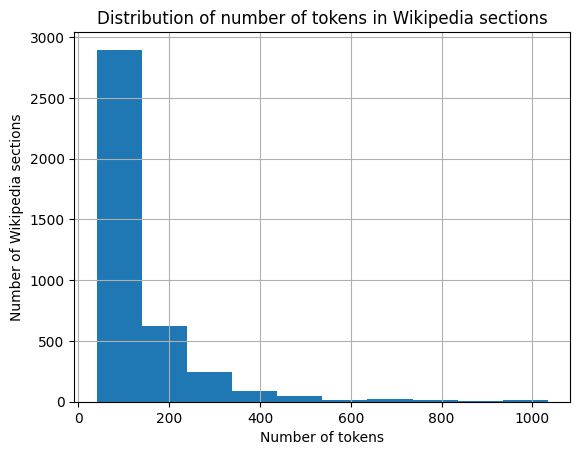

In [33]:
from matplotlib import pyplot as plt

df = pd.read_csv('olympics-data/olympics_sections.csv')
df[['tokens']].hist()
# add axis descriptions and title
plt.xlabel('Number of tokens')
plt.ylabel('Number of Wikipedia sections')
plt.title('Distribution of number of tokens in Wikipedia sections')
plt.show()